In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
import pandas_datareader.data as web

In [2]:
tech_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [3]:
# identify a time period when stock would be analyzed 
year = datetime.today().year
month = datetime.today().month
day = datetime.today().day
end = "%s-%s-%s" %(year-1,month,day)
start = "%s-%s-%s" %(year-2,month,day)

In [4]:
# pull data from quandl
for stock in tech_list:
    globals()[stock] = web.DataReader(stock, 'quandl', start, end, access_key="2R89GBx5133ux-s5Gmad")

<center> Basic Analysis </center>

In [5]:
def basic_plot (df, company_name):
    plt.figure()
    plt.subplot(211)
    df['AdjClose'].plot(figsize=(18,10), color='r')
    plt.ylabel("Adjusted Closing Price (US dollar)", fontsize=15)
    plt.title("%s Stock from %s to %s" %(company_name, start,end), fontsize=20) 
    
    plt.subplot(212)
    df['Volume'].plot(figsize=(18,10))
    plt.title("%s Stock from %s to %s" %(company_name, start,end), fontsize=20) 
    plt.ylabel("Number of Shares", fontsize=15)
    
    plt.tight_layout()

In [6]:
def moving_avg (df, company_name):
    MA_day = [20,30,50]
    for MA in MA_day:
        column_name = "MA for %s days" %(str(MA))
        df[column_name] = AAPL['AdjClose'].rolling(MA).mean()
        
    df[['AdjClose', 'MA for 20 days', 'MA for 30 days', 'MA for 50 days']].plot(legend=True, figsize=(18,8))
    plt.title('Moving Average of %s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    plt.ylabel("(US dollar)", fontsize=15)
    

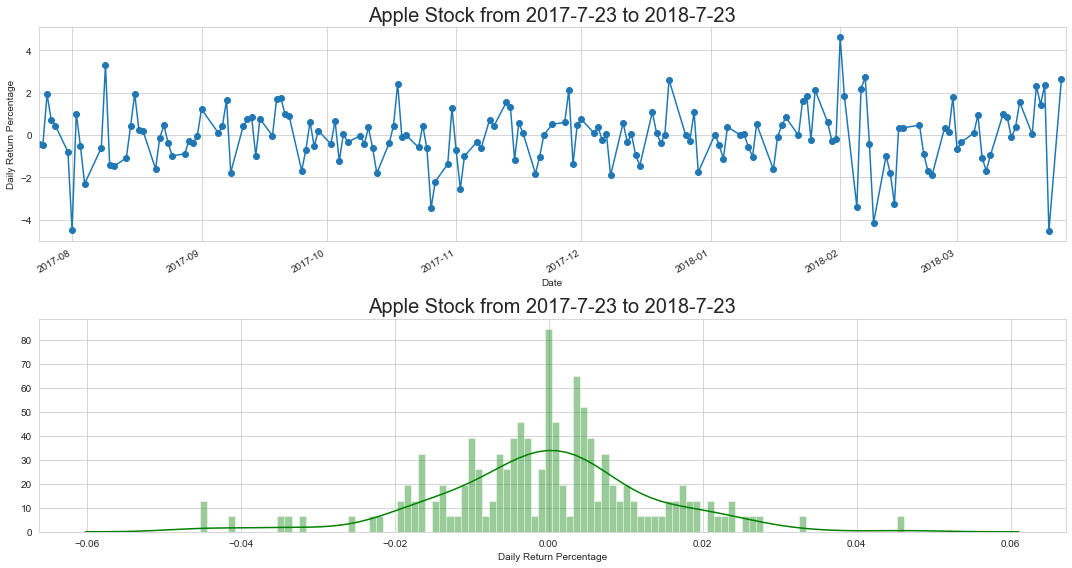

In [7]:
def daily_return (df, company_name):
    plt.figure()
    plt.subplot(211)
    df['Daily Return'] = df['AdjClose'].pct_change()
    df['Daily Return'].multiply(100).plot(figsize=(15,8), marker='o')
    plt.ylabel('Daily Return Percentage')
    plt.title('%s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    
    plt.subplot(212)
    sns.distplot(df['Daily Return'].dropna(), bins=100, color='green')
    plt.xlabel('Daily Return Percentage')
    plt.title('%s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    
    plt.tight_layout()

daily_return(AAPL, "Apple")

<center> Basic Analysis of Google Stock </center>

In [8]:
closing_df = pd.DataFrame(list([AAPL['AdjClose'],GOOGL['AdjClose'],MSFT['AdjClose'],AMZN['AdjClose']])).T
closing_df.columns = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [9]:
# calculate daily percentage return
tech_rets = closing_df.pct_change()

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


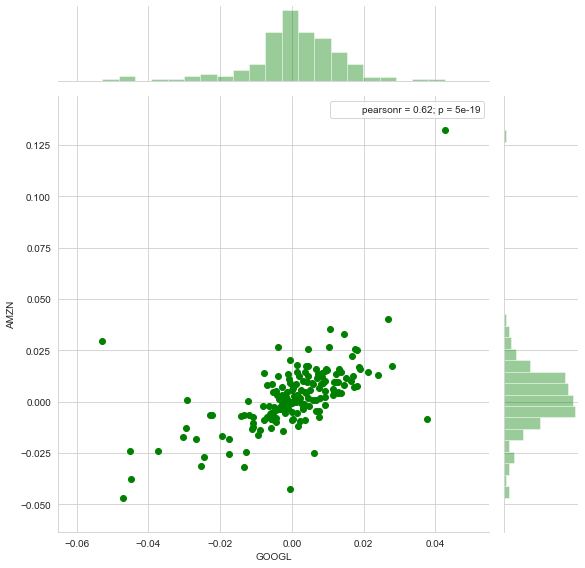

In [10]:
g = sns.JointGrid(x='GOOGL',y='AMZN', data=tech_rets, size=8)
g = g.plot_joint(plt.scatter, color = 'green')
g = g.plot_marginals(sns.distplot, kde=False, color="green")
g.annotate(stats.pearsonr)

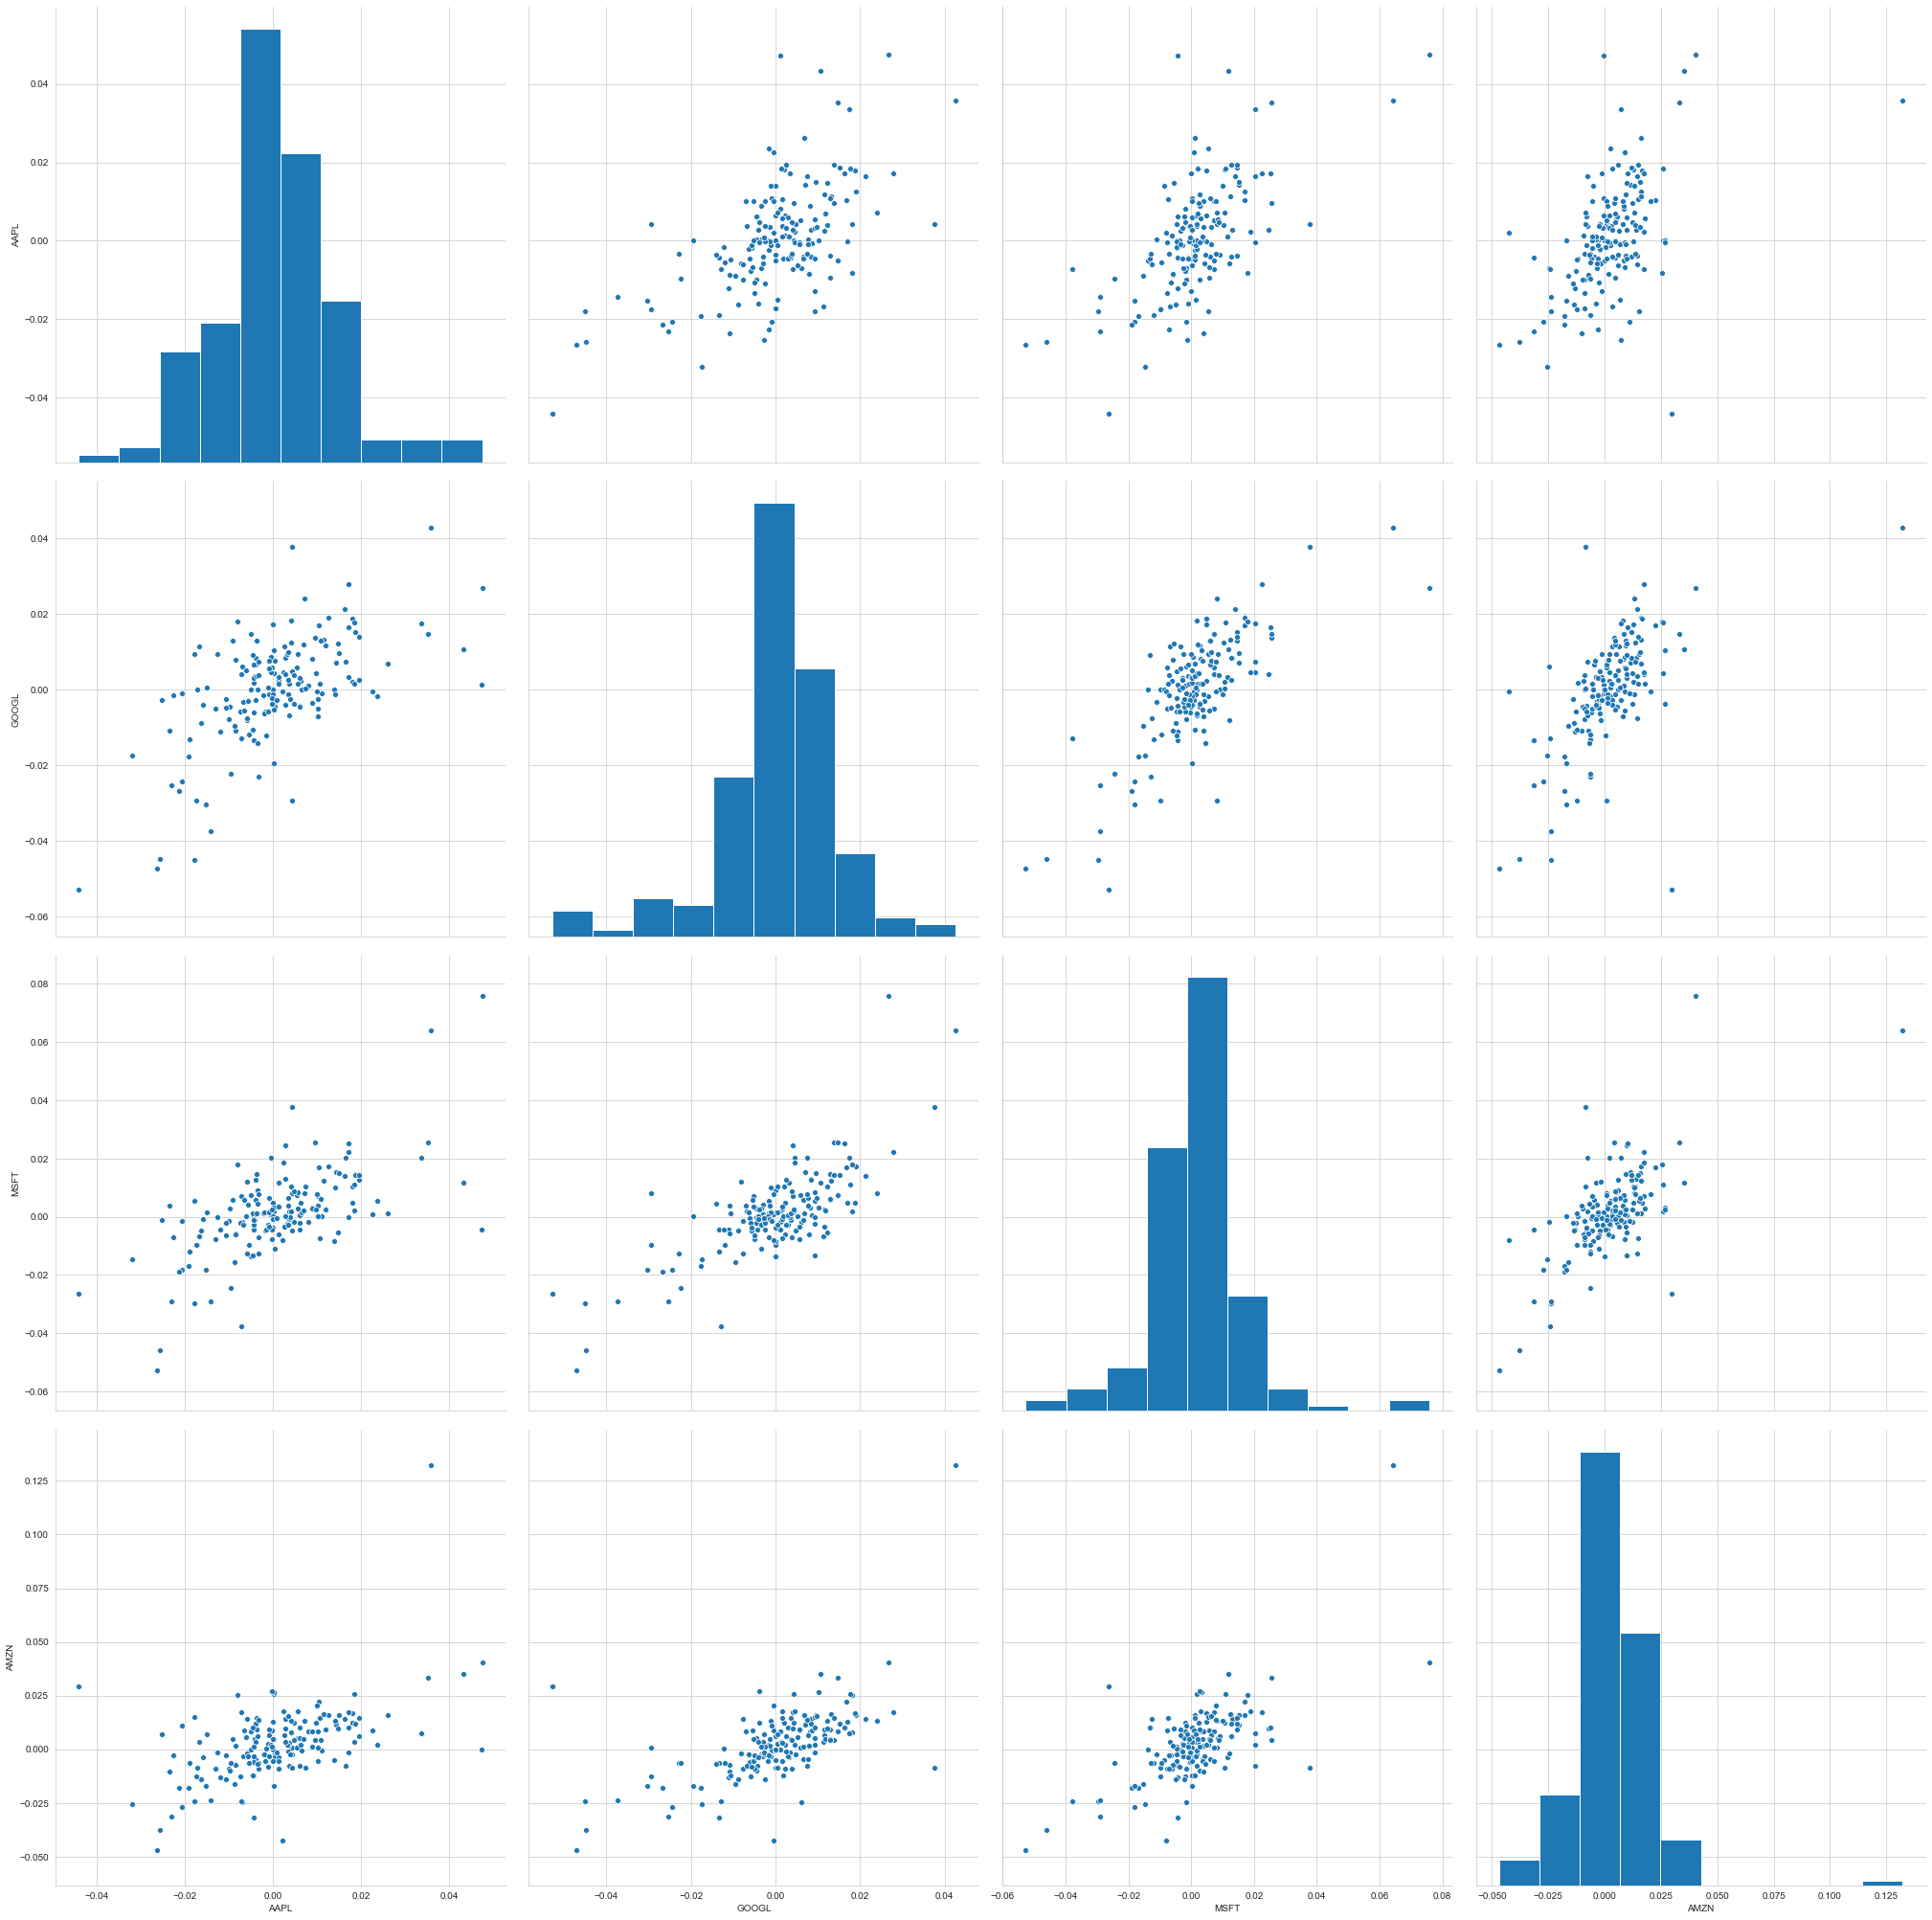

In [11]:
f = sns.pairplot(data=tech_rets.dropna(), height=7)

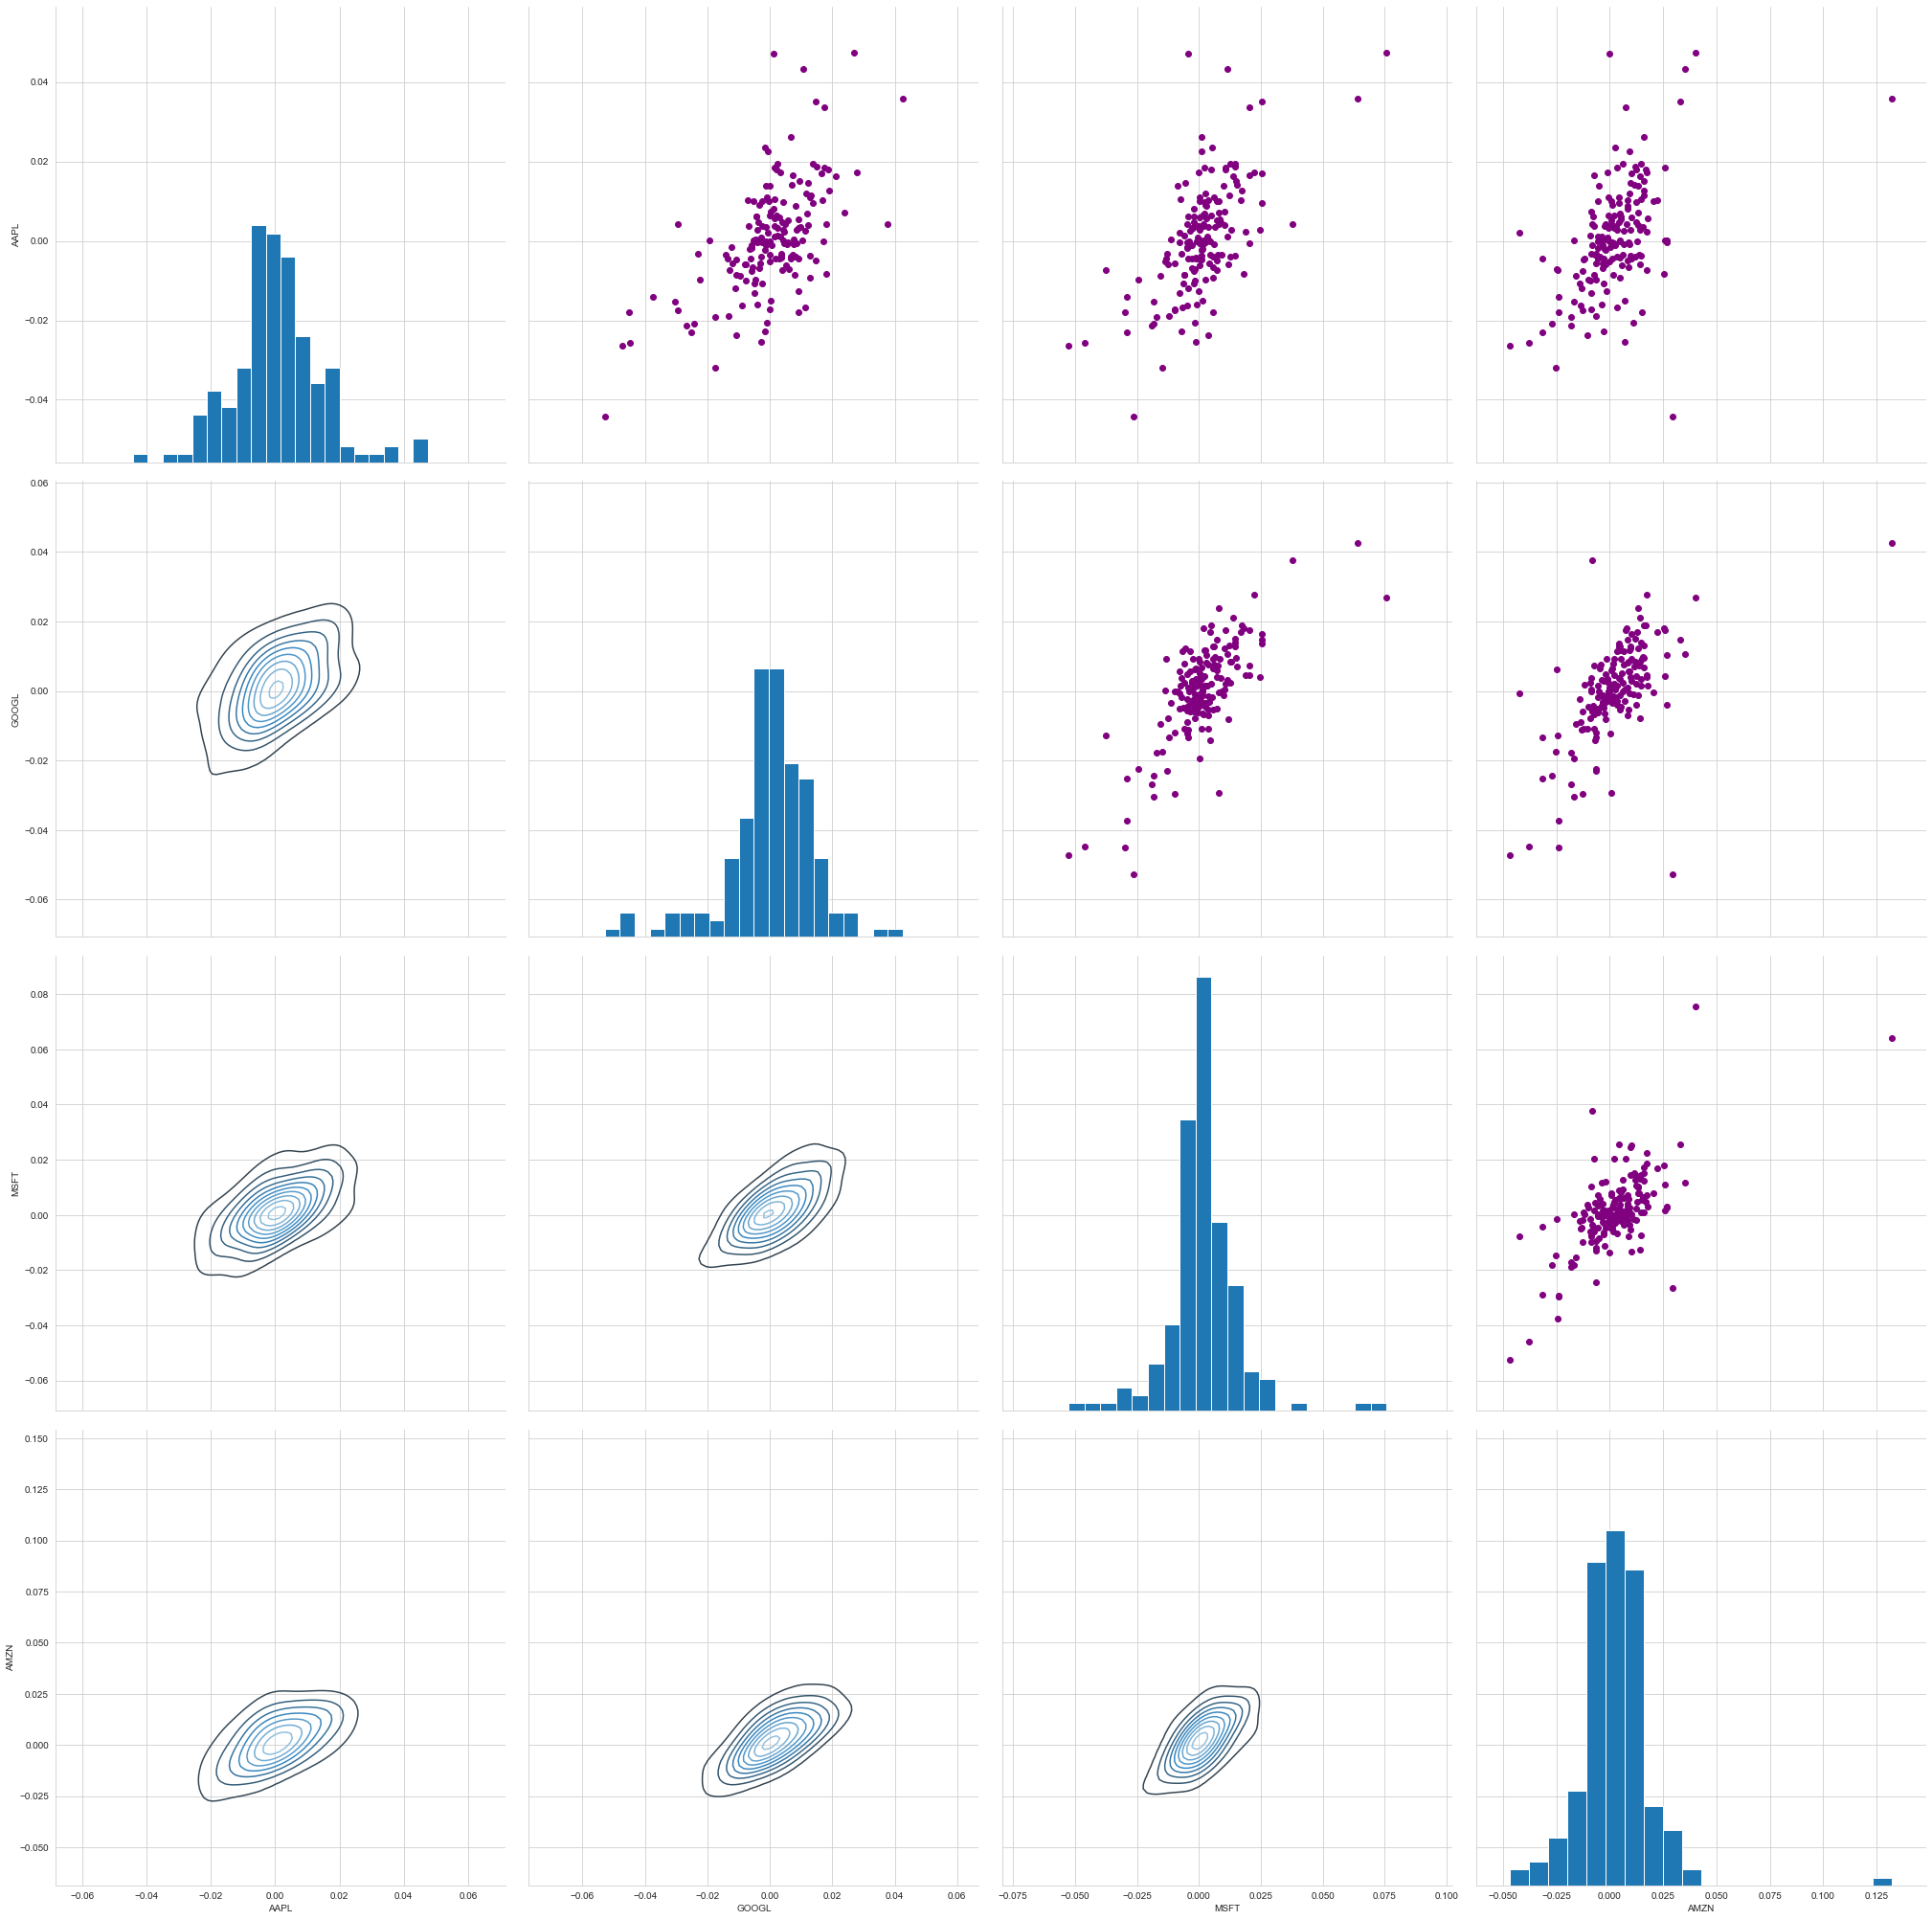

In [12]:
j = sns.PairGrid(tech_rets.dropna(), height=7)
j.map_upper(plt.scatter, color='purple')
j.map_lower(sns.kdeplot, cmap='Blues_d')
j.map_diag(plt.hist, bins=20)

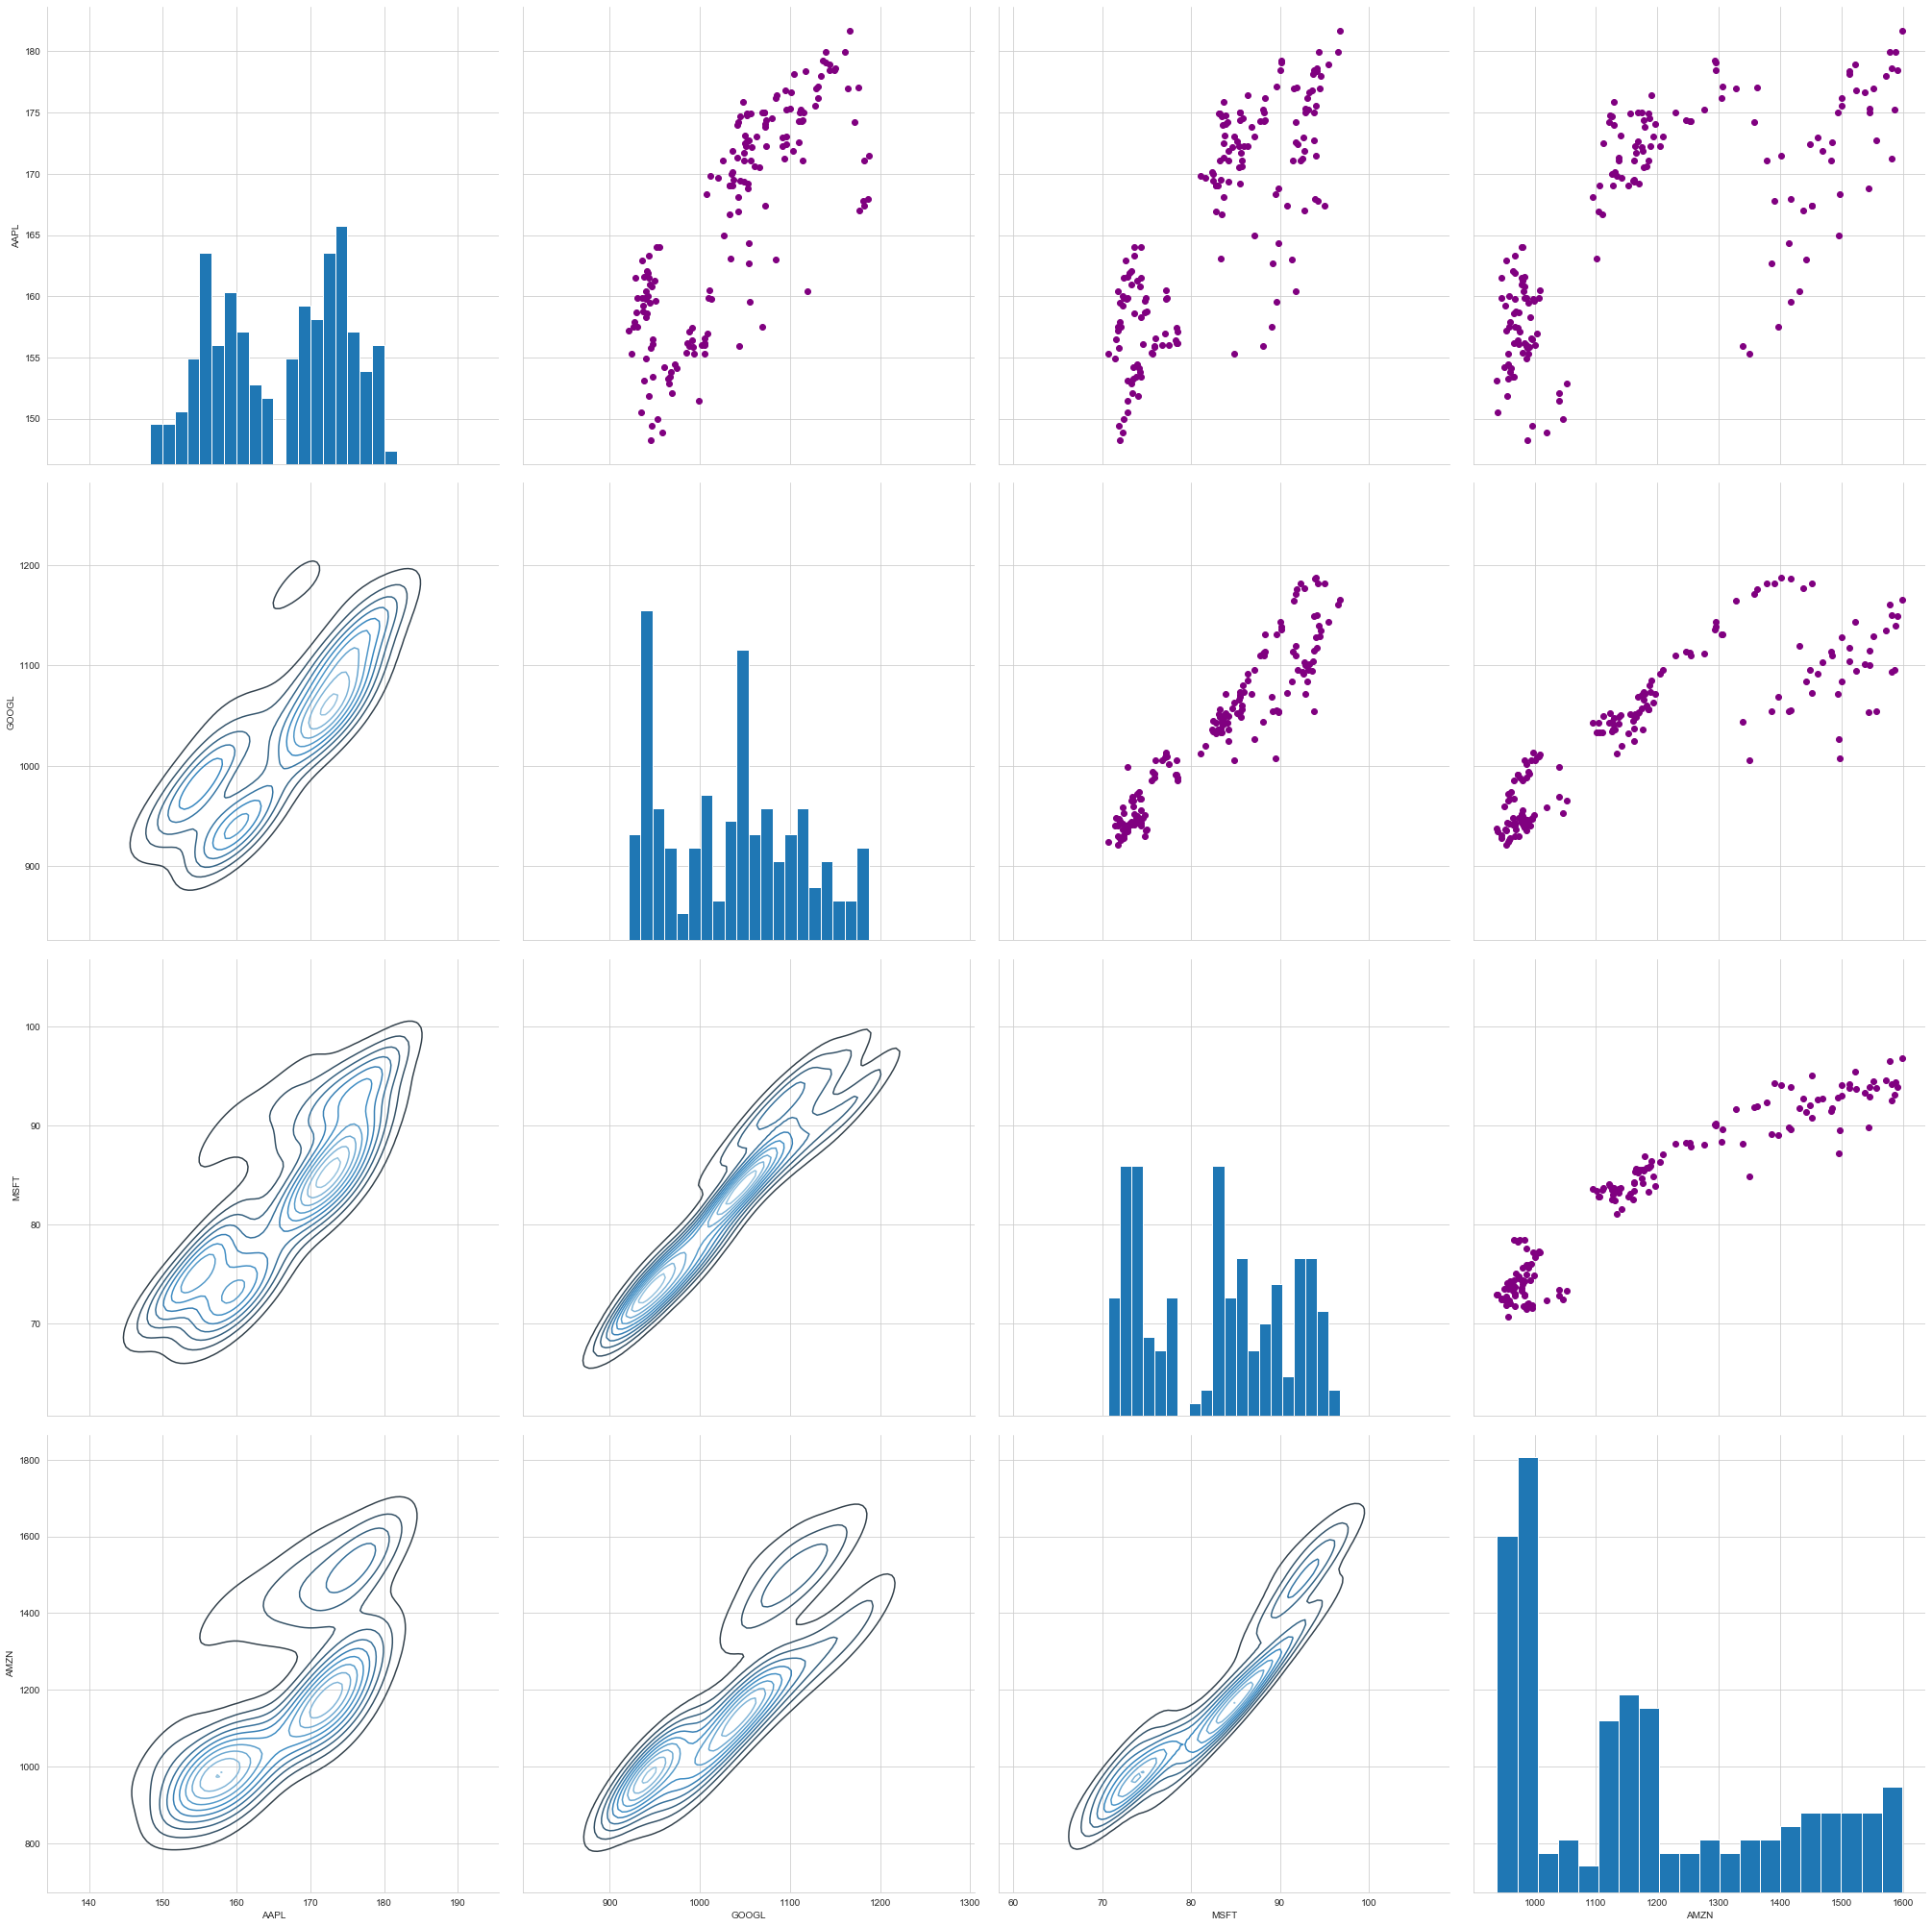

In [13]:
# Closing price 
j = sns.PairGrid(closing_df.dropna(), height=7)
j.map_upper(plt.scatter, color='purple')
j.map_lower(sns.kdeplot, cmap='Blues_d')
j.map_diag(plt.hist, bins=20)

In [14]:
tech_rets.corr(method='pearson')

,AAPL,GOOGL,MSFT,AMZN
AAPL,1.000000,0.605205,0.634247,0.518039
GOOGL,0.605205,1.000000,0.758880,0.615929
MSFT,0.634247,0.758880,1.000000,0.673197
AMZN,0.518039,0.615929,0.673197,1.000000


In [15]:
closing_df.corr(method='pearson')

,AAPL,GOOGL,MSFT,AMZN
AAPL,1.000000,0.798433,0.813465,0.705238
GOOGL,0.798433,1.000000,0.943537,0.839779
MSFT,0.813465,0.943537,1.000000,0.943734
AMZN,0.705238,0.839779,0.943734,1.000000


<h2> Risk Analysis </h2>

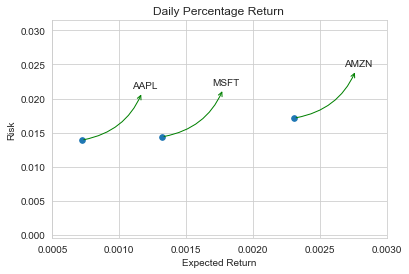

In [16]:
rets = tech_rets.dropna()
plt.scatter(x=rets.mean(), y=rets.std(), s=np.pi*10)
plt.xlabel('Expected Return')
plt.ylabel('Risk')
plt.title('Daily Percentage Return ')
plt.xlim(0.0005, 0.003)
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        arrowprops = dict(arrowstyle = '<-', connectionstyle = 'arc3,rad=-0.3', color='g'))

<h2> Value at Risk: Empirical Quantiles </h2>

In [17]:
rets['GOOGL'].quantile(0.01)

-0.04574855311506782

In [18]:
rets['AAPL'].quantile(0.01)

-0.02823879176662167

In [19]:
rets['AMZN'].quantile(0.01)

-0.039293393616216546

In [20]:
rets['MSFT'].quantile(0.01)

-0.04037018324244637

<h2> Value at Risk: Monte Carlo

In [21]:
days=365
dt=1/days
mu=rets['GOOGL'].mean()
sigma=rets['GOOGL'].std()
GOOGL.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.0,1.0,1063.90,1064.54,997.62,1006.94,2940957.0
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.0,1.0,1050.60,1059.27,1010.58,1054.09,3272409.0
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.0,1.0,1051.37,1066.78,1024.87,1026.55,2413517.0
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.0,1.0,1080.01,1083.92,1049.64,1053.15,3418154.0
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.0,1.0,1092.57,1108.70,1087.21,1094.00,1990515.0


In [22]:
def monte_carlo (start_price,dt,mu,sigma,days):
    price=np.zeros(days)
    shock=np.zeros(days)
    drift=np.zeros(days)
    price[0]=start_price
    
    for i in range(1,days):
        shock[i] = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt))
        drift[i] = mu*dt 
        price[i] = price[i-1] + price[i-1]*(drift[i] + shock[i])
    return price
            

Text(0.5, 1.0, 'Monte Carlo Simulation of Google Stock')

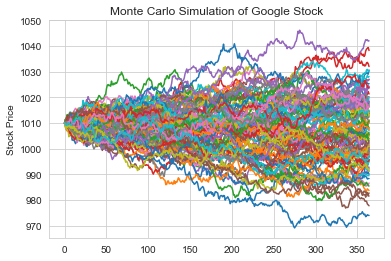

In [23]:
for x in range(100):
    plt.plot(monte_carlo(1010,dt,mu,sigma,days))
plt.ylabel('Stock Price')
plt.title('Monte Carlo Simulation of Google Stock')

In [24]:
runs = 500
simulation = np.zeros(runs)
for j in range(runs):
    simulation[j] = monte_carlo(1010,dt,mu,sigma,days)[-1]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,  0.,  3.,
         2.,  3.,  2.,  3.,  9.,  5.,  1.,  5.,  5.,  5.,  4.,  2.,  3.,
         6.,  6.,  6.,  8.,  5., 13.,  7., 13., 14.,  7., 13.,  9., 14.,
        16., 15., 12., 11., 11., 12., 15., 10., 15., 11., 10.,  9.,  9.,
        13., 13., 12., 12., 12.,  9., 10.,  7.,  9.,  6.,  7.,  7.,  6.,
         4.,  5.,  5.,  6.,  3.,  2.,  0.,  1.,  3.,  2.,  1.,  3.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 970.96944036,  971.85698855,  972.74453675,  973.63208494,
         974.51963314,  975.40718133,  976.29472952,  977.18227772,
         978.06982591,  978.95737411,  979.8449223 ,  980.7324705 ,
         981.62001869,  982.50756688,  983.39511508,  984.28266327,
         985.17021147,  986.05775966,  986.94530786,  987.83285605,
         988.72040425,  989.60795244,  990.49550063,  991.38304883,
         992.27059702,  99

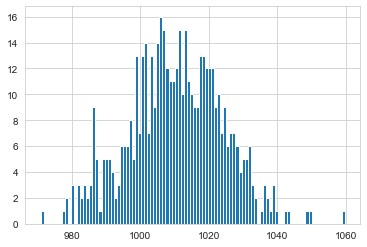

In [25]:
plt.hist(simulation,bins=100)

In [26]:
simulation.mean()

1010.2973845653106